# Module 8 #

Convert a 3D image into a spherical harmonic representation using CellOrganizer SPHARM-RPDM functionality

Then create both a mesh reconstruction and an image reconstruction from the SPHARM-RPDM representation 


In [1]:
#import packages
from aicsimageio import AICSImage
import numpy as np
from pathlib import Path
from cellorganizer.tools import image2SPHARMparameterization, SPHARMparameterization2image, SPHARMparameterization2mesh
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

# Image 2 SPHARM PARAMS #

In [2]:
#set options
options = {}
options['NMfirsttry_maxiter'] = 300
options['NMretry_maxiter'] = 100
options['NMretry_maxiterbig'] = 300

# decreasing these numbers decreases compute time but potential reduces model quality
options['NMcost_tol'] = 1e-7
options['NMlargr_tol'] = 1e-7

# degree of spherical harmonic descriptor
options['maxDeg'] = 31
# if the error in the parameterization for a given cell is higher than this, discard that cell
# (note that there is a separate option hd_threshold that controls which cells are in reports)
options['hd_thresh'] = 10

In [31]:
#read in selected image
directory = '/home/murphylab/cellorganizer/local/images/HeLa/3D/processed/'
cellImagesDirectoryPath = Path(directory + 'LAM_cell1_ch1_t1_down_128-128-9.tif')
img = AICSImage(cellImagesDirectoryPath)

In [32]:
data = img.data
data = np.squeeze(data) #get it down to a 3D image
data = np.transpose(data, (1, 2, 0)) #transpose to xyz
print(data.shape)
#downsample
#data = data[::8,::8,::2]
#make sure data is shaped correctly
print(data.shape)

(128, 128, 9)
(128, 128, 9)


In [33]:
#print(np.max(data))
print(data[75,48,0])

113


In [34]:
params = image2SPHARMparameterization(data, options) #return back descriptors as dict

v2.10 Cellorganizer
R2019 MATLAB


In [35]:
params

{'deg': 31,
 'fvec': array([[ 2.35179152e+02+4.68209949e-19j,  2.80523361e+02+1.75578731e-18j,
          1.32791466e+01-2.92631218e-19j],
        [ 4.58758205e+01+1.54838307e+01j, -8.25408798e+00-1.86266109e+01j,
         -2.78220535e+00+7.60023734e+00j],
        [-1.02377741e+01-4.68247810e-18j, -7.23942106e+01+1.46327441e-18j,
         -3.03365862e+00-1.31694697e-19j],
        ...,
        [ 1.10952458e-02+1.05877537e-02j, -7.43830112e-03-2.28047356e-03j,
          8.23212897e-03-2.04463884e-02j],
        [-2.79508371e-03+2.26496239e-03j,  2.68907767e-03-1.47757414e-03j,
         -2.82611611e-02+1.04240815e-02j],
        [-9.87356211e-03+5.33024978e-04j, -4.96576840e-03+8.94321079e-04j,
          1.19296001e-02+1.21103879e-02j]]),
 'vertices': array([[ 56,  29,   0],
        [ 57,  29,   0],
        [ 58,  29,   0],
        ...,
        [ 71, 102,   9],
        [ 72, 102,   9],
        [ 73, 102,   9]], dtype=uint8),
 'faces': array([[4373, 4360, 3574, 3605],
        [4386, 4373, 360

# SPHARM PARAMS 2 MESH #

In [36]:
#set options
options = {}
#options['meshtype.type'] = 'even'
#options['meshtype.nPhi'] = 64
#options['meshtype.nTheta'] = 32

options['meshtype.type'] = 'triangular';
options['meshtype.nVertices'] = 4002;

options['figtitle'] = []
options['plot'] = 0 #show mesh figure
options['dpi'] = 150

In [37]:
mesh_mat = SPHARMparameterization2mesh(params, options)

v2.10 Cellorganizer
R2019 MATLAB


In [38]:
mesh_mat

{'Zvert': array([[ 55.37511883,  25.24003889,   0.99219531],
        [ 54.56435279,  23.45599406,   1.05855468],
        [ 56.31963839,  28.29994826,   0.52283759],
        ...,
        [ 67.61283129, 107.24166866,   5.69960604],
        [ 69.96517125, 106.93915104,   5.2849118 ],
        [ 69.44685525, 106.88637652,   5.63119432]]),
 'fs': array([[1971, 2115, 2026],
        [1759, 1903, 1814],
        [1759, 1848, 1903],
        ...,
        [3692, 3747, 3713],
        [3692, 3726, 3747],
        [3726, 3781, 3747]], dtype=uint16)}

4002
8000


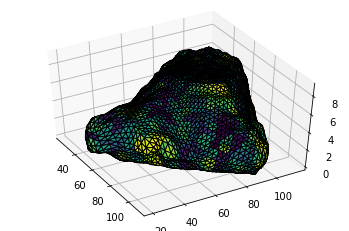

In [61]:
# now create a 3D visualization from the mesh

# vertices
v = mesh_mat['Zvert']
print(len(v))
# faces
f = mesh_mat['fs']-1
print(len(f))

# assign a "color number" equal to the index of the face
C = np.array(list(range(len(mesh_mat['fs']))))
## an alternative is to assign each face a "color number" matching its average z coordinate
#C=np.empty(len(f))
#for itup in range(len(f)):
#    C[itup]=np.mean(v[f[itup]], axis=0)[2]
# normalize the color numbers to range 0-1
norm = plt.Normalize(C.min(), C.max())
# assign a color to each face
colors = plt.cm.viridis(norm(C))

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

pc = art3d.Poly3DCollection(v[f], facecolors=colors, edgecolor="black")
ax.add_collection(pc)
vmins = np.amin(v, axis=0)
vmaxs = np.amax(v, axis=0)
ax.set_xlim(vmins[0], vmaxs[0])
ax.set_ylim(vmins[1], vmaxs[1])
ax.set_zlim(vmins[2], vmaxs[2])

elevation = 45
azimuth = 330
ax.view_init(elevation, azimuth)
plt.show()

# SPHARM PARAMS 2 IMAGE #

In [78]:
options['cropping'] = 'tight'
options['oversampling_scale'] = 1
options['debug'] = True
print(options)
img_mat = SPHARMparameterization2image(params, options)
print(img_mat.shape)

{'meshtype.type': 'triangular', 'meshtype.nVertices': 4002, 'figtitle': [], 'plot': 0, 'dpi': 150, 'debug': True, 'image.cropping': 'tight', 'image.oversampling_scale': 1, 'cropping': 'tight', 'oversampling_scale': 1}
v2.10 Cellorganizer
R2019 MATLAB
(117, 114, 10)


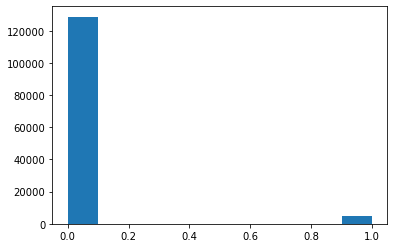

In [75]:
fig=plt.figure()
plt.hist(img_mat.ravel())
plt.show()

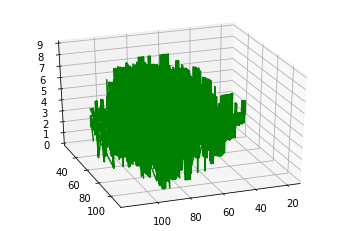

In [76]:
abovezeroind = np.argwhere(img_mat)
fig = plt.figure()
ax = plt.axes(projection ='3d')
ax.view_init(elev=30, azim=70)  
ax.plot3D(abovezeroind[:,0],abovezeroind[:,1],abovezeroind[:,2],'green')
plt.show()

4


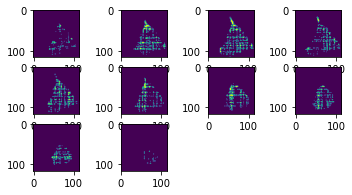

In [77]:
fig = plt.figure()
#islice = round(img_mat.shape[2]/2)
import math
panels = math.ceil(math.sqrt(img_mat.shape[2]))
print(panels)
for i in range(img_mat.shape[2]):
    plt.subplot(panels,panels,i+1)
    plt.imshow(img_mat[:,:,i])
plt.show()